In [1]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path("..").resolve()))

In [2]:
import os
import numpy as np
import pandas as pd
import torch

from torch.utils.data import DataLoader, Subset

from datasets import cfg
from datasets.base import collate_bb
from datasets.loader import DataConfig, DataModule

from models.models import build_model
import mlflow.pytorch

from train.metrics import get_metrics_split_size, pairwise_iou_masks
from train.plotting import plot_predictions

torch.set_grad_enabled(False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

/home/neoph/dev/Train/.tenv312/lib/python3.12/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/home/neoph/dev/Train/.tenv312/lib/python3.12/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


device(type='cuda')

In [3]:
DATA_CONF = DataConfig(batch_size=1, num_workers=2)
DATA = DataModule(DATA_CONF, num_channels=3, with_masks=True)
loader= DATA.make_loader_custom()
ds = DATA.ds_custom


In [ ]:
model_uri = "file:///media/sdb1/mlflow/811912879539272586/f5a5b06105074b00add2d669786d3dff/artifacts/model"
m2 = mlflow.pytorch.load_model(model_uri).to(device)
m2.eval()


Examples: B-test, Att model


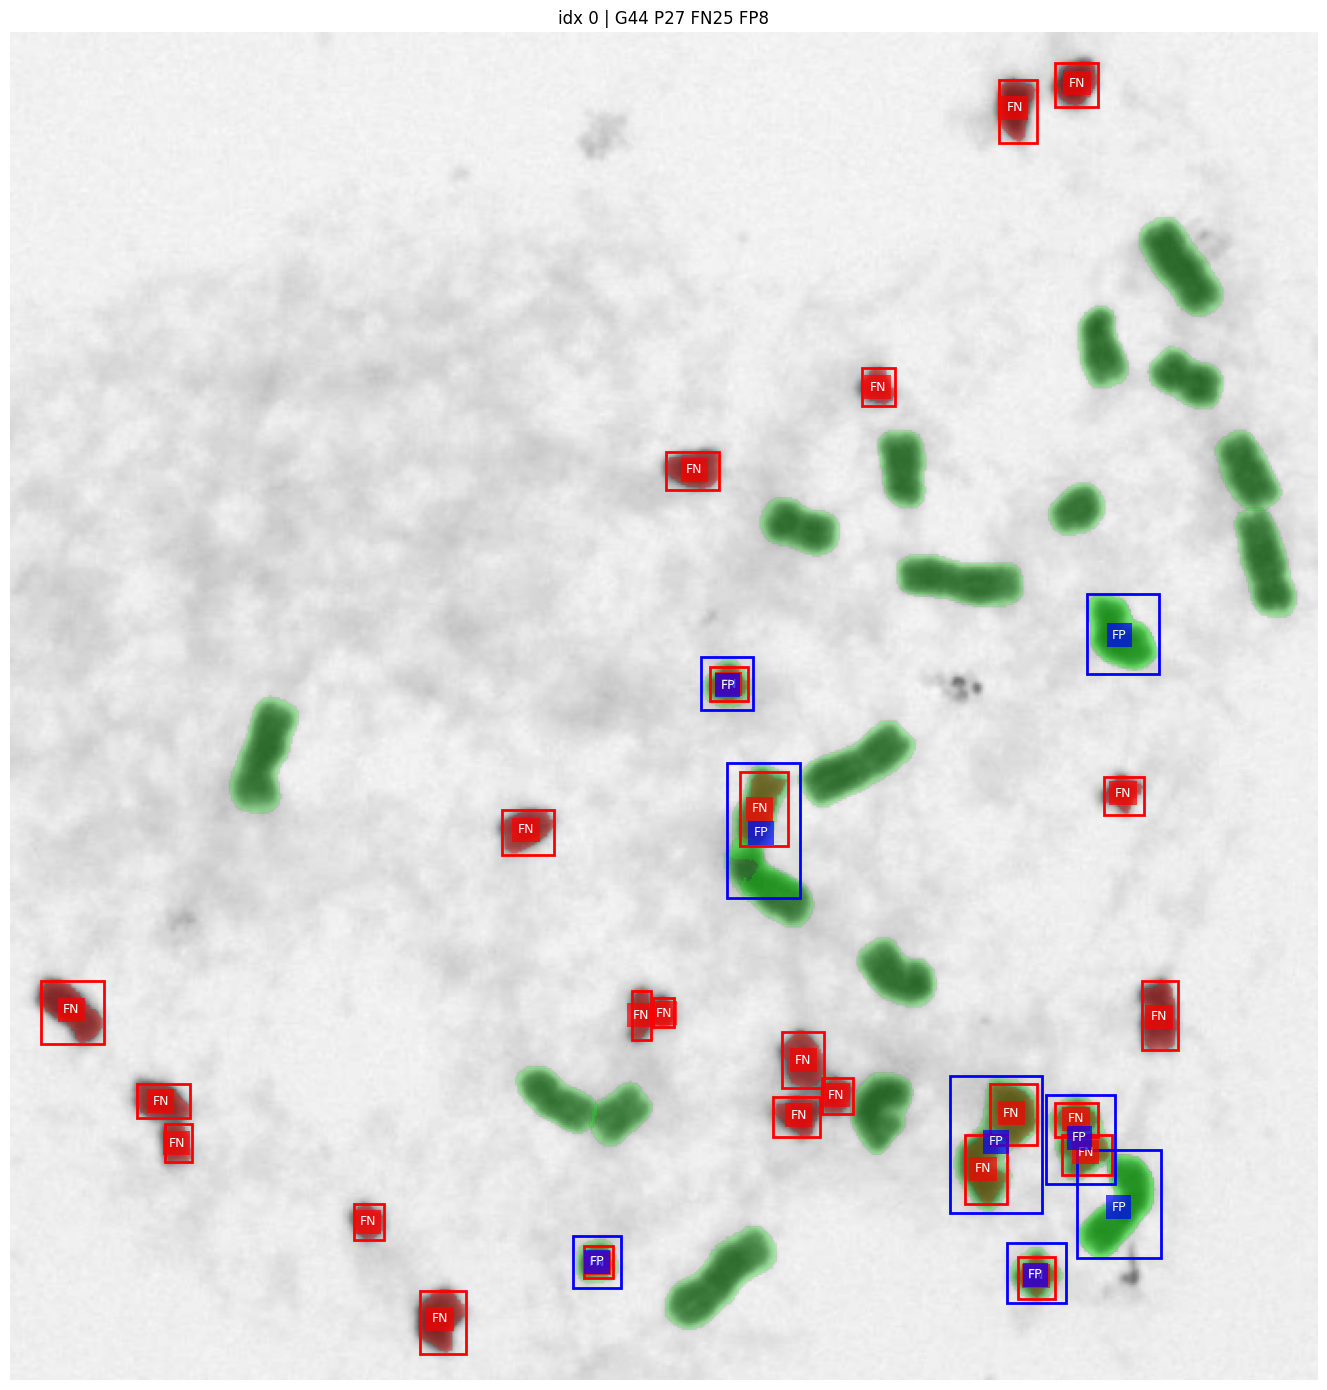

In [5]:
from train.eval import Evaluator
e = Evaluator(device)
e.show_examples(ds, m2, n=1, score_thresh=0.5, title="B-test, Att model", with_gt=True, with_class=False)

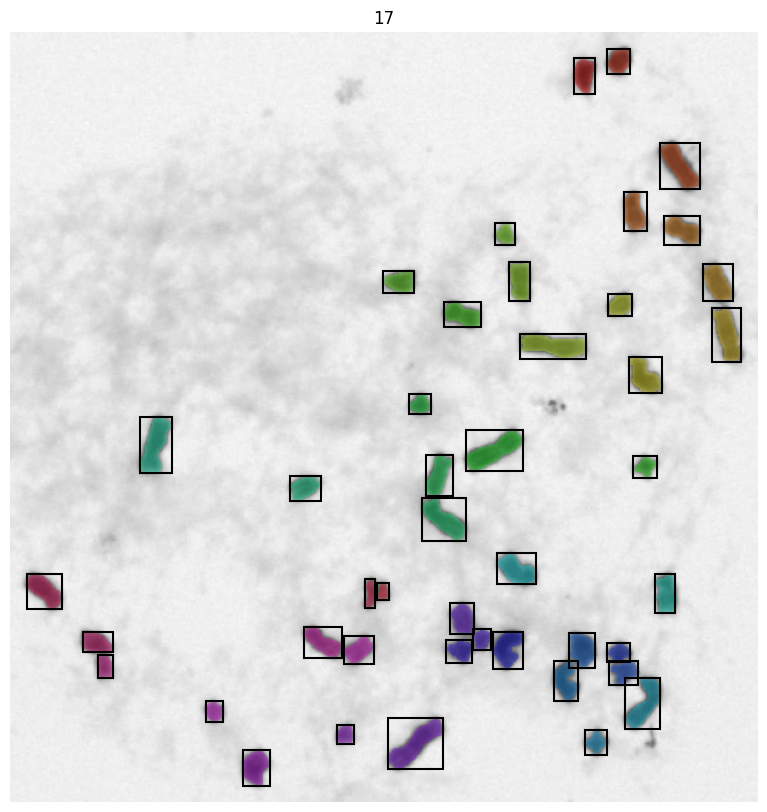

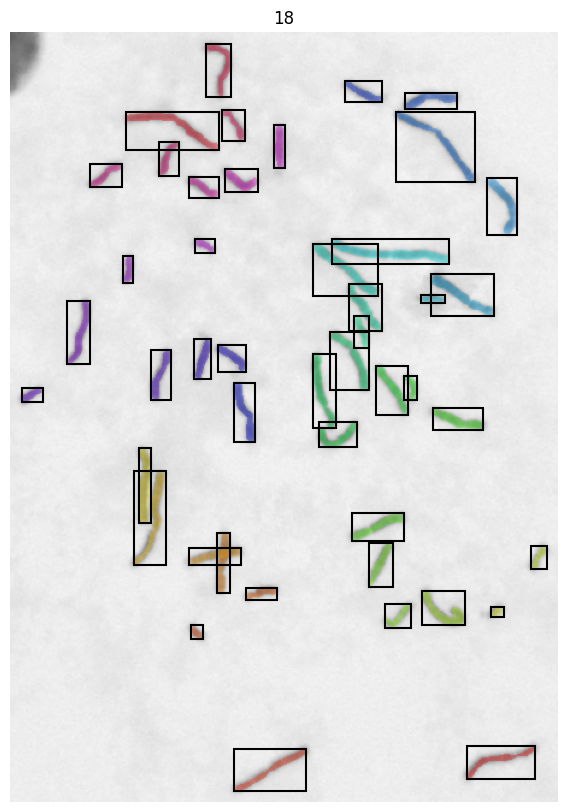

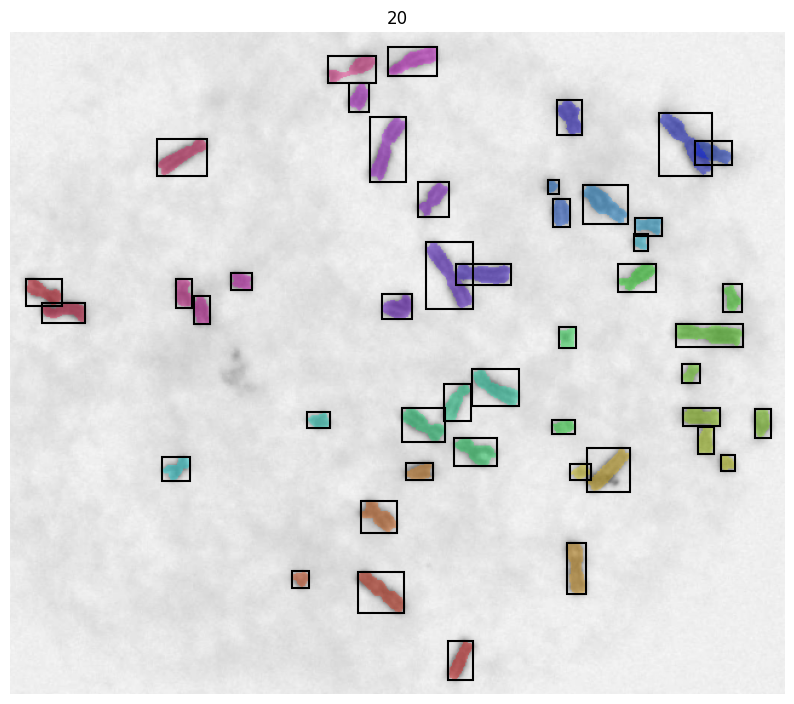

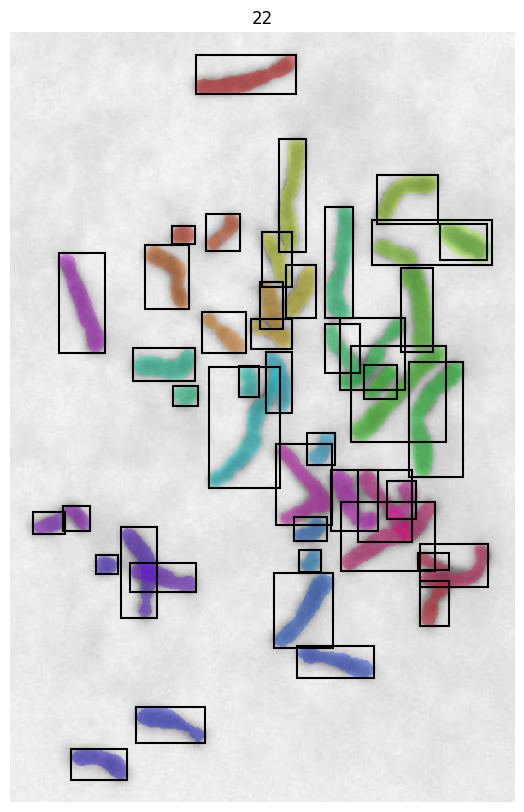

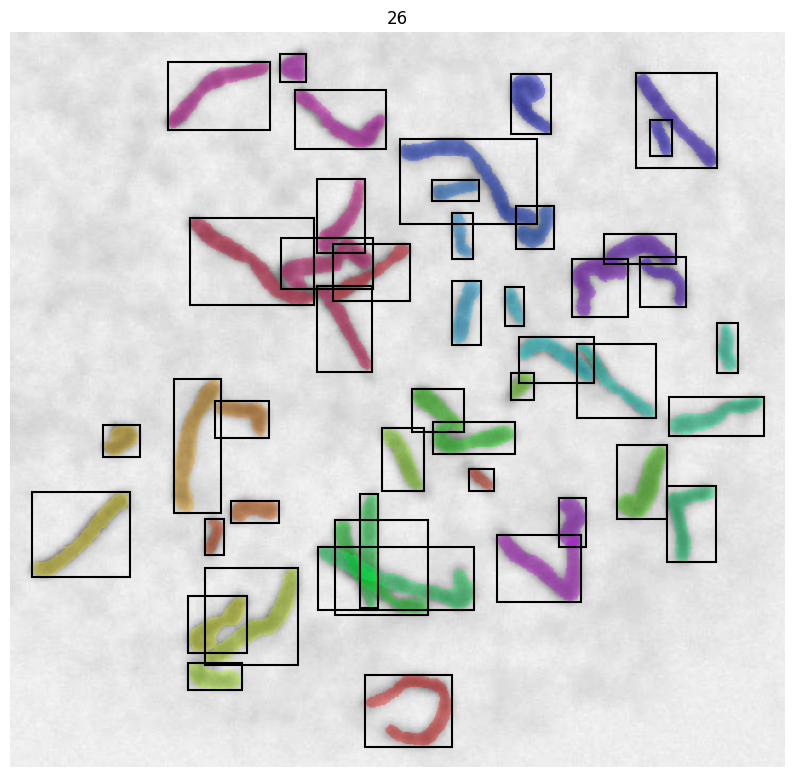

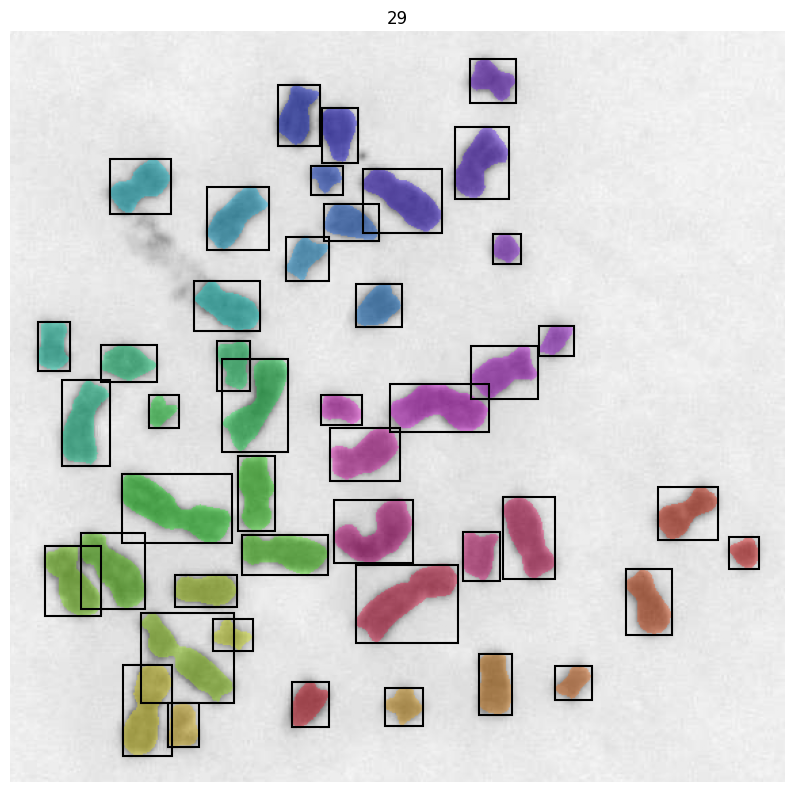

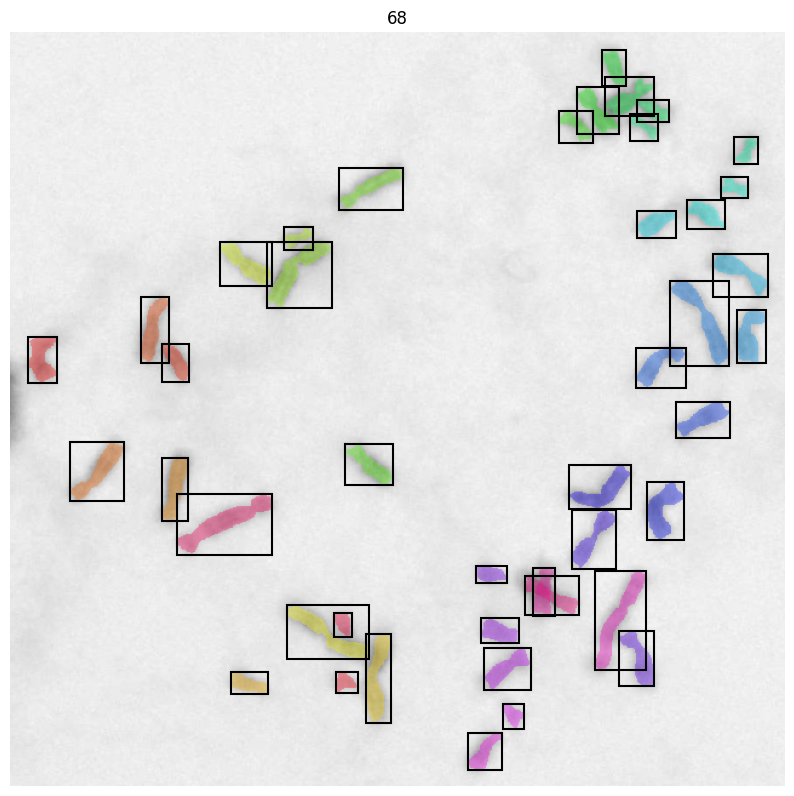

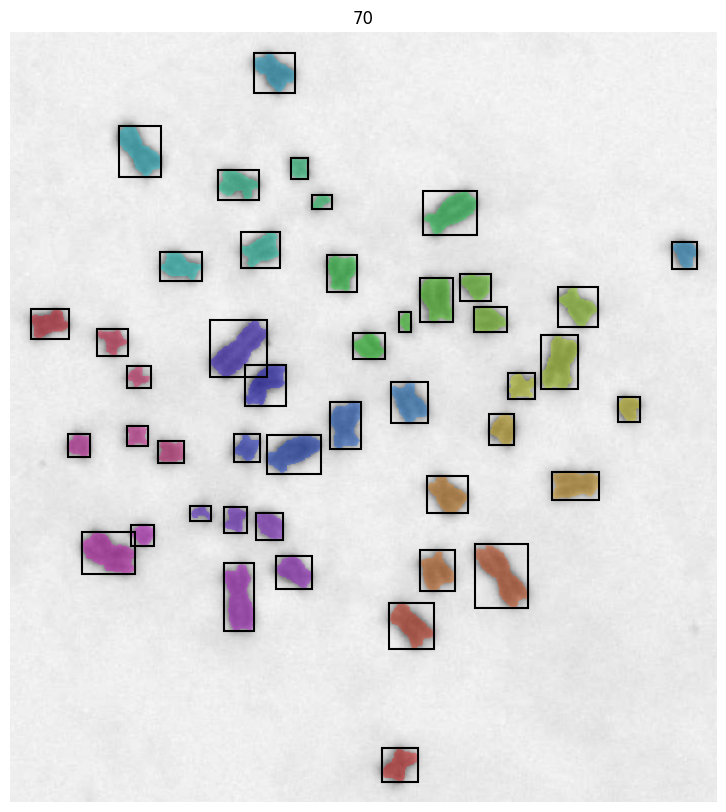

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle



def show_instance_sample(img_t, target, alpha=0.35, draw_boxes=True):
    img = img_t.detach().cpu()
    if img.shape[0] == 3:
        x = img.permute(1, 2, 0).numpy()
        x = (x + 1) / 2
        x = np.clip(x, 0, 1)
    else:
        x = img[0].numpy()
        x = (x + 1) / 2
        x = np.clip(x, 0, 1)

    masks = target["masks"].detach().cpu().numpy().astype(bool)
    boxes = target["boxes"].detach().cpu().numpy()

    H = masks.shape[1] if masks.size else (x.shape[0] if x.ndim == 2 else x.shape[0])
    W = masks.shape[2] if masks.size else (x.shape[1] if x.ndim == 2 else x.shape[1])

    plt.figure(figsize=(10, 10))
    if x.ndim == 2:
        plt.imshow(x, cmap="gray")
    else:
        plt.imshow(x)

    n = masks.shape[0]
    cmap = plt.get_cmap("hsv", max(n, 1))

    for k in range(n):
        m = masks[k]
        if not m.any():
            continue
        c = cmap(k)[:3]
        overlay = np.zeros((H, W, 4), dtype=np.float32)
        overlay[..., 0] = c[0]
        overlay[..., 1] = c[1]
        overlay[..., 2] = c[2]
        overlay[..., 3] = m.astype(np.float32) * alpha
        plt.imshow(overlay)

        if draw_boxes:
            x1, y1, x2, y2 = boxes[k]
            plt.gca().add_patch(Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, linewidth=1.5))

    title = target.get("image_id_str", "")
    if isinstance(title, str) and title:
        plt.title(title)
    plt.axis("off")
    plt.show()




for i in range(min(8, len(ds))):
    img_t, target = ds[i]
    show_instance_sample(img_t, target, alpha=0.35, draw_boxes=True)